SixHumpCamel synthetic function:

GP ERM versus STP nu = 3 ERM (winner)

https://www.sfu.ca/~ssurjano/camel6.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.7 MB/s 
     |████████████████████████████████| 872 kB 53.5 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=9d8e390f8c3228459f14ffefec02f9334a7bbd90b1312f9fe6ac9c096b4b5c59
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=f97c06b2079f09b5bfbdcc051941b717f1b389e930e2ddc62e03086bb426a83a
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'SixHumpCamel'
n_test = 500 # test points
df = 3 # nu

util_gp = 'RegretMinimized'
util_stp = 'tRegretMinimized'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'SixHumpCamel':
    
    # True y bounds:
    y_lb = -1.0316
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb_x1 = -3
    ub_x1 = +3
    
    lb_x2 = -2
    ub_x2 = +2
    
# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}
    
# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)
    

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation

In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Acquisition function - ERM:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'RegretMinimized': self.RegretMinimized,
            'tRegretMinimized': self.tRegretMinimized
        }

        self.f = mode_dict[mode]
   
    def RegretMinimized(self, tau, mean, std):
        
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return z * (std + self.eps) * norm.cdf(z) + (std + self.eps) * norm.pdf(z)[0]
    
    def tRegretMinimized(self, tau, mean, std, nu=3.0):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + (std + self.eps) * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)
    

In [9]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_1 = GPGO(surrogate_gp_1, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.49786797  0.88129797]. 	  0.2650082867644827 	 0.2650082867644827
init   	 [-2.99931375 -0.79066971]. 	  -110.13991869176735 	 0.2650082867644827
init   	 [-2.11946466 -1.63064562]. 	  -26.90935479429681 	 0.2650082867644827
init   	 [-1.88243873 -0.61775709]. 	  -2.8558363102363344 	 0.2650082867644827
init   	 [-0.61939515  0.15526694]. 	  -1.0540522096005847 	 0.2650082867644827
1      	 [-1.19090548 -0.31694205]. 	  -2.4158974691999036 	 0.2650082867644827
2      	 [-0.20496717  1.78860261]. 	  -27.938307482599367 	 0.2650082867644827
3      	 [ 3.         -0.85938812]. 	  -105.54945612064061 	 0.2650082867644827
4      	 [3. 2.]. 	  -162.89999999999998 	 0.2650082867644827
5      	 [-0.59640429 -0.4737148 ]. 	  -0.7584334477155306 	 0.2650082867644827
6      	 [-0.65513346 -0.35813321]. 	  -1.143697148042604 	 0.2650082867644827
7      	 [-0.68772963 -0.29781267]. 	  -1.3388915825031935 	 0.2650082867644827
8  

In [10]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_2 = GPGO(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.38403059 -1.89629507]. 	  -38.61280125654363 	 -0.011939608840498828
init   	 [ 0.29797487 -0.25871043]. 	  -0.011939608840498828 	 -0.011939608840498828
init   	 [-0.47779319 -0.67866072]. 	  -0.1381453419305213 	 -0.011939608840498828
init   	 [-1.7721082   0.47708387]. 	  -0.626144759281101 	 -0.011939608840498828
init   	 [-1.20207196 -0.9326909 ]. 	  -3.0693811601417798 	 -0.011939608840498828
1      	 [-0.42476117 -0.03918374]. 	  -0.6657981553034664 	 -0.011939608840498828
2      	 [ 1.68995655 -0.11116565]. 	  -1.8233740408450951 	 -0.011939608840498828
3      	 [3. 2.]. 	  -162.89999999999998 	 -0.011939608840498828
4      	 [ 3. -2.]. 	  -150.89999999999998 	 -0.011939608840498828
5      	 [0.11639073 2.        ]. 	  -48.28658410960645 	 -0.011939608840498828
6      	 [-3.  2.]. 	  -150.89999999999998 	 -0.011939608840498828
7      	 [-3. -2.]. 	  -162.89999999999998 	 -0.011939608840498828
8      	 [-2.56

In [11]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_3 = GPGO(surrogate_gp_3, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.30478742 0.83259129]. 	  0.2431922946563294 	 0.2431922946563294
init   	 [-1.25457157  0.04331042]. 	  -2.3313310458730996 	 0.2431922946563294
init   	 [2.35768173 1.58517236]. 	  -33.54152175045586 	 0.2431922946563294
init   	 [-2.24648814 -1.17102849]. 	  -14.214109412296352 	 0.2431922946563294
init   	 [-2.69119678 -0.23676063]. 	  -45.87579771712209 	 0.2431922946563294
1      	 [-0.21459765  0.23025045]. 	  0.0704423164450177 	 0.2431922946563294
2      	 [-0.49337921  1.16293966]. 	  -2.1868332576107044 	 0.2431922946563294
3      	 [ 0.0877683  -0.56336094]. 	  0.8853498372559109 	 0.8853498372559109
4      	 [ 0.0663957  -0.50620029]. 	  0.7783385251483066 	 0.8853498372559109
5      	 [ 0.0534111  -0.47037006]. 	  0.7029183637888664 	 0.8853498372559109
6      	 [ 0.04493833 -0.44700015]. 	  0.6515599619289595 	 0.8853498372559109
7      	 [ 0.03953826 -0.43247473]. 	  0.6190614457905591 	 0.885349837255

In [12]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_4 = GPGO(surrogate_gp_4, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.80217903 0.188929  ]. 	  -63.70212732873661 	 -2.3196402150601703
init   	 [2.83610616 0.85926397]. 	  -71.43837110827245 	 -2.3196402150601703
init   	 [ 1.18637295 -1.13564202]. 	  -2.5463267765341566 	 -2.3196402150601703
init   	 [ 2.85764673 -1.97507898]. 	  -113.76785286351424 	 -2.3196402150601703
init   	 [-1.48210583 -0.26083387]. 	  -2.3196402150601703 	 -2.3196402150601703
1      	 [ 0.12626012 -1.09757571]. 	  -0.9109071443411083 	 -0.9109071443411083
2      	 [ 0.15931999 -1.06485198]. 	  -0.5378979538717611 	 -0.5378979538717611
3      	 [-3.  2.]. 	  -150.89999999999998 	 -0.5378979538717611
4      	 [-3. -2.]. 	  -162.89999999999998 	 -0.5378979538717611
5      	 [-0.28282789 -0.08067361]. 	  -0.30365314188521697 	 -0.30365314188521697
6      	 [ 0.09013544 -0.66305218]. 	  1.0128311517758304 	 1.0128311517758304
7      	 [ 0.08391973 -0.64651905]. 	  0.999285050327336 	 1.0128311517758304
8      	 [ 

In [13]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_5 = GPGO(surrogate_gp_5, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.66804097  1.48292922]. 	  -10.126030408244933 	 0.6512780061070701
init   	 [-1.75968507  1.67444363]. 	  -19.4300499315822 	 0.6512780061070701
init   	 [-0.06953287  0.44697545]. 	  0.6512780061070701 	 0.6512780061070701
init   	 [1.59544714 0.07367195]. 	  -2.168775388880503 	 0.6512780061070701
init   	 [-1.21919699 -1.24911509]. 	  -7.420330936884148 	 0.6512780061070701
1      	 [0.3857265  1.13871156]. 	  -2.5276755327379994 	 0.6512780061070701
2      	 [ 3. -2.]. 	  -150.89999999999998 	 0.6512780061070701
3      	 [3. 2.]. 	  -162.89999999999998 	 0.6512780061070701
4      	 [ 0.45387604 -0.13660101]. 	  -0.6025627985788967 	 0.6512780061070701
5      	 [-3. -2.]. 	  -162.89999999999998 	 0.6512780061070701
6      	 [-0.0783965  -0.41997527]. 	  0.5236490019717478 	 0.6512780061070701
7      	 [-0.07119764 -0.40122548]. 	  0.491478071057054 	 0.6512780061070701
8      	 [-0.06589228 -0.38852882]. 	  0.469

In [14]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_6 = GPGO(surrogate_gp_6, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.35716091 -0.67208078]. 	  -11.995980169715628 	 0.3096187466378422
init   	 [ 1.92737474 -1.8332135 ]. 	  -31.167927894156623 	 0.3096187466378422
init   	 [-2.35405992  0.38020826]. 	  -13.013381745677465 	 0.3096187466378422
init   	 [ 0.17890417 -0.32477029]. 	  0.3096187466378422 	 0.3096187466378422
init   	 [-0.9875529   0.49007773]. 	  -0.9989196280666852 	 0.3096187466378422
1      	 [0.2290865  0.98917957]. 	  -0.3465525235542021 	 0.3096187466378422
2      	 [3. 2.]. 	  -162.89999999999998 	 0.3096187466378422
3      	 [-0.09906757  0.27140284]. 	  0.26076676252374176 	 0.3096187466378422
4      	 [-0.09855403  0.27692565]. 	  0.27186554674050134 	 0.3096187466378422
5      	 [-1.22719283 -2.        ]. 	  -52.85406400442485 	 0.3096187466378422
6      	 [-0.05530024  0.61836295]. 	  0.9666380935201604 	 0.9666380935201604
7      	 [-0.05659497  0.62178809]. 	  0.9709799442195857 	 0.9709799442195857
8     

In [15]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_7 = GPGO(surrogate_gp_7, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.54215026  1.11967517]. 	  -26.53843863832488 	 0.46481072558790276
init   	 [-0.36954461  0.89386071]. 	  0.46481072558790276 	 0.46481072558790276
init   	 [2.86793707 0.15398348]. 	  -76.66051064695093 	 0.46481072558790276
init   	 [ 0.00672278 -1.71179547]. 	  -22.613010892757885 	 0.46481072558790276
init   	 [-1.38936612e+00 -4.69996698e-04]. 	  -2.294585534557751 	 0.46481072558790276
1      	 [0.16121662 1.7545766 ]. 	  -25.980871892344787 	 0.46481072558790276
2      	 [ 2.08143936 -0.31498517]. 	  -4.006029431355211 	 0.46481072558790276
3      	 [ 1.18351027 -0.35588359]. 	  -1.5350817087151063 	 0.46481072558790276
4      	 [-0.37424687  0.48601799]. 	  0.383594391405703 	 0.46481072558790276
5      	 [-0.76036043  0.79902079]. 	  -0.14418488075070213 	 0.46481072558790276
6      	 [0.03906163 0.32941707]. 	  0.36799395523255707 	 0.46481072558790276
7      	 [-3. -2.]. 	  -162.89999999999998 	 0.4648107

In [16]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_8 = GPGO(surrogate_gp_8, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.24057642 1.87416265]. 	  -48.82879577505094 	 -0.03190064766213015
init   	 [2.21516724 0.12342277]. 	  -8.660623551418242 	 -0.03190064766213015
init   	 [-1.60363003 -1.95440478]. 	  -48.28332373939171 	 -0.03190064766213015
init   	 [-0.41718709 -0.39059456]. 	  -0.2801229037700297 	 -0.03190064766213015
init   	 [ 0.13604803 -0.08643282]. 	  -0.03190064766213015 	 -0.03190064766213015
1      	 [-0.84228478  0.91558374]. 	  -0.5864343738000131 	 -0.03190064766213015
2      	 [-3.  2.]. 	  -150.89999999999998 	 -0.03190064766213015
3      	 [-0.27001932  0.4386089 ]. 	  0.4592996355476947 	 0.4592996355476947
4      	 [-0.27227671  0.42623368]. 	  0.4255978937321288 	 0.4592996355476947
5      	 [-0.27346317  0.41859608]. 	  0.4050255178462272 	 0.4592996355476947
6      	 [-0.27417166  0.41342685]. 	  0.39122412813367197 	 0.4592996355476947
7      	 [-0.27463364  0.40971754]. 	  0.38138554123987256 	 0.4592996355

In [17]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_9 = GPGO(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.93775508  0.00749837]. 	  -92.35857237145763 	 -1.395407492769129
init   	 [-0.02536024 -1.46468188]. 	  -9.867672894921913 	 -1.395407492769129
init   	 [-2.14733349 -1.1257653 ]. 	  -10.24680089963123 	 -1.395407492769129
init   	 [-0.48895092 -1.00759533]. 	  -1.395407492769129 	 -1.395407492769129
init   	 [-2.49564209 -0.61800544]. 	  -24.58298635463645 	 -1.395407492769129
1      	 [0.20087506 1.2956128 ]. 	  -4.974772100042532 	 -1.395407492769129
2      	 [ 3.         -0.22076027]. 	  -108.05227926250552 	 -1.395407492769129
3      	 [-1.45414596  2.        ]. 	  -47.311747509184165 	 -1.395407492769129
4      	 [-1.57054129 -2.        ]. 	  -53.23319972947514 	 -1.395407492769129
5      	 [-0.50961948 -0.13404216]. 	  -0.9007741863881611 	 -0.9007741863881611
6      	 [1.96414584 2.        ]. 	  -55.24423071573652 	 -0.9007741863881611
7      	 [-0.01755752 -0.13269613]. 	  0.06563016133049356 	 0.065630161

In [18]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_10 = GPGO(surrogate_gp_10, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.62792386 -1.9169922 ]. 	  -38.25414770674631 	 -0.7775687473184012
init   	 [0.80188941 0.99521553]. 	  -2.552651714051803 	 -0.7775687473184012
init   	 [-0.00895793 -1.10081342]. 	  -1.0367630165263393 	 -0.7775687473184012
init   	 [-1.81162281  1.04212285]. 	  -0.7775687473184012 	 -0.7775687473184012
init   	 [-1.98533498 -1.64664074]. 	  -25.383481436170044 	 -0.7775687473184012
1      	 [3. 2.]. 	  -162.89999999999998 	 -0.7775687473184012
2      	 [-3.  2.]. 	  -150.89999999999998 	 -0.7775687473184012
3      	 [-0.97453316  0.37274809]. 	  -1.348480034205919 	 -0.7775687473184012
4      	 [ 3.         -0.31734861]. 	  -107.5856837146818 	 -0.7775687473184012
5      	 [-0.5891859   0.83922221]. 	  0.17807259252024998 	 0.17807259252024998
6      	 [-0.65569297  0.76426403]. 	  0.11477805934642471 	 0.17807259252024998
7      	 [-0.68873864  0.7305229 ]. 	  0.03812114548834189 	 0.17807259252024998
8      	 [

In [19]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_11 = GPGO(surrogate_gp_11, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.91838187 -1.92209903]. 	  -46.39910375151002 	 0.6254688257880329
init   	 [-0.22068884  0.89973572]. 	  0.6254688257880329 	 0.6254688257880329
init   	 [-0.47877837 -0.05829161]. 	  -0.8249470187639529 	 0.6254688257880329
init   	 [-2.92331511 -0.05051357]. 	  -88.99028404075307 	 0.6254688257880329
init   	 [2.65083991 1.40318036]. 	  -51.423425402262914 	 0.6254688257880329
1      	 [ 1.79063726 -2.        ]. 	  -46.64254246955394 	 0.6254688257880329
2      	 [-0.42003216  2.        ]. 	  -47.802108630641015 	 0.6254688257880329
3      	 [ 0.09429169 -0.00574364]. 	  -0.03472439478003897 	 0.6254688257880329
4      	 [ 0.08276052 -0.00260124]. 	  -0.027056458121901918 	 0.6254688257880329
5      	 [ 0.07672207 -0.00090945]. 	  -0.023399329995854014 	 0.6254688257880329
6      	 [0.0730166  0.00015318]. 	  -0.02127714539359677 	 0.6254688257880329
7      	 [0.07052171 0.00088308]. 	  -0.019900505534536265 	 0.6

In [20]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_12 = GPGO(surrogate_gp_12, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.07502295  0.96019879]. 	  -2.6185857163917037 	 -1.9967735906956543
init   	 [-1.42010991  0.13495757]. 	  -1.9967735906956543 	 -1.9967735906956543
init   	 [-2.91255023  1.67498803]. 	  -101.67816714332157 	 -1.9967735906956543
init   	 [ 2.40428912 -1.86631429]. 	  -47.44624883788006 	 -1.9967735906956543
init   	 [ 2.74169602 -1.45116271]. 	  -58.32400185681089 	 -1.9967735906956543
1      	 [-1.2477584  0.9198662]. 	  -0.7267928205662857 	 -0.7267928205662857
2      	 [1.77328709 2.        ]. 	  -53.72420422974635 	 -0.7267928205662857
3      	 [-3. -2.]. 	  -162.89999999999998 	 -0.7267928205662857
4      	 [-0.16304956 -2.        ]. 	  -48.43096180942048 	 -0.7267928205662857
5      	 [-0.56695593  2.        ]. 	  -47.94593653385309 	 -0.7267928205662857
6      	 [-1.22619909  0.24116394]. 	  -1.884989355487105 	 -0.7267928205662857
7      	 [-1.23740627  0.24737985]. 	  -1.8619519445127457 	 -0.7267928205662

In [21]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_13 = GPGO(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.66621446 -1.04983512]. 	  -0.752930921147986 	 -0.752930921147986
init   	 [1.9456712  1.86299679]. 	  -41.05776363102951 	 -0.752930921147986
init   	 [ 2.83560668 -0.18620301]. 	  -69.0134544723513 	 -0.752930921147986
init   	 [0.65425478 1.10210606]. 	  -3.117452174069064 	 -0.752930921147986
init   	 [0.84968007 0.88807292]. 	  -2.006601529383926 	 -0.752930921147986
1      	 [ 0.68819929 -1.55983024]. 	  -14.332396382766602 	 -0.752930921147986
2      	 [-3.         0.1441294]. 	  -108.386244780951 	 -0.752930921147986
3      	 [-1.18947978  2.        ]. 	  -48.0207425461905 	 -0.752930921147986
4      	 [0.31737209 0.12269227]. 	  -0.3615671266530721 	 -0.3615671266530721
5      	 [0.3208117  0.12860491]. 	  -0.3659948524789032 	 -0.3615671266530721
6      	 [0.32255309 0.13164693]. 	  -0.368146996144656 	 -0.3615671266530721
7      	 [0.32360629 0.13350142]. 	  -0.3694192590924201 	 -0.3615671266530721
8    

In [22]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_14 = GPGO(surrogate_gp_14, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.08366006 1.09266021]. 	  -1.0453292732107575 	 1.029299726828387
init   	 [ 2.22256611 -1.96781221]. 	  -48.81113313056442 	 1.029299726828387
init   	 [-1.14158445  1.83041496]. 	  -31.794043287944216 	 1.029299726828387
init   	 [ 0.07870027 -0.7268623 ]. 	  1.029299726828387 	 1.029299726828387
init   	 [ 0.23519962 -1.11498023]. 	  -1.161934062902255 	 1.029299726828387
1      	 [-1.4544454   0.80460528]. 	  -0.13632292703505466 	 1.029299726828387
2      	 [ 0.06051083 -1.22941829]. 	  -3.032505907483532 	 1.029299726828387
3      	 [ 0.07221267 -0.58197053]. 	  0.9171399719969583 	 1.029299726828387
4      	 [ 2.28584625 -1.87403497]. 	  -42.12313738585593 	 1.029299726828387
5      	 [ 0.05156011 -0.18537694]. 	  0.13167384505154514 	 1.029299726828387
6      	 [-1.62233454  0.24541874]. 	  -1.4335115362537232 	 1.029299726828387
7      	 [ 0.55082075 -0.3029371 ]. 	  -0.5293510496183202 	 1.029299726828387
8 

In [23]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_15 = GPGO(surrogate_gp_15, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.09290618 -1.2844163 ]. 	  -6.84252100896936 	 -2.1163170846379233
init   	 [-2.67382071 -0.55384622]. 	  -43.69785230561242 	 -2.1163170846379233
init   	 [-1.34759443  0.1200009 ]. 	  -2.1163170846379233 	 -2.1163170846379233
init   	 [-1.16448651 -0.78210256]. 	  -2.3544087277459513 	 -2.1163170846379233
init   	 [-2.32955234 -1.00040394]. 	  -15.469119251600274 	 -2.1163170846379233
1      	 [-0.25714052  1.36624973]. 	  -6.374883133491508 	 -2.1163170846379233
2      	 [3. 2.]. 	  -162.89999999999998 	 -2.1163170846379233
3      	 [-3.  2.]. 	  -150.89999999999998 	 -2.1163170846379233
4      	 [-0.23930258 -0.51468311]. 	  0.43350570349947654 	 0.43350570349947654
5      	 [-0.25722929 -0.50665369]. 	  0.37732002117668184 	 0.43350570349947654
6      	 [-0.26633193 -0.50276006]. 	  0.3483199462265014 	 0.43350570349947654
7      	 [-0.27184683 -0.50069549]. 	  0.3310089634345319 	 0.43350570349947654
8      	 [

In [24]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_16 = GPGO(surrogate_gp_16, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.66025353  0.09265337]. 	  -1.8632773736203017 	 -1.8632773736203017
init   	 [ 0.30420874 -1.8175922 ]. 	  -30.24114424375299 	 -1.8632773736203017
init   	 [-0.83562699 -1.10767623]. 	  -3.922061281476444 	 -1.8632773736203017
init   	 [ 1.13235697 -1.3450743 ]. 	  -6.7121671493737685 	 -1.8632773736203017
init   	 [-2.5780508   1.76404344]. 	  -53.42443470756798 	 -1.8632773736203017
1      	 [ 3.         -0.02175059]. 	  -108.83285676520858 	 -1.8632773736203017
2      	 [-3. -2.]. 	  -162.89999999999998 	 -1.8632773736203017
3      	 [0.52364005 2.        ]. 	  -49.993059006085105 	 -1.8632773736203017
4      	 [-0.849958    0.00561249]. 	  -1.914500797155091 	 -1.8632773736203017
5      	 [-1.02889713 -0.08098713]. 	  -2.3337866625156605 	 -1.8632773736203017
6      	 [ 2.29756817 -2.        ]. 	  -55.03475841716943 	 -1.8632773736203017
7      	 [-0.77479579 -0.15236217]. 	  -1.743915764583875 	 -1.74391576458

In [25]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_17 = GPGO(surrogate_gp_17, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.23200998  0.12234702]. 	  -2.189206652278967 	 -1.7722768782964888
init   	 [-1.85087528 -1.72839857]. 	  -29.406067820453675 	 -1.7722768782964888
init   	 [1.72191276 0.62533409]. 	  -2.2113401446731897 	 -1.7722768782964888
init   	 [0.82512538 0.30241158]. 	  -1.7722768782964888 	 -1.7722768782964888
init   	 [-2.7656225  -0.56874558]. 	  -57.5922315952177 	 -1.7722768782964888
1      	 [-0.57939852  1.17144643]. 	  -2.48356156718488 	 -1.7722768782964888
2      	 [ 3. -2.]. 	  -150.89999999999998 	 -1.7722768782964888
3      	 [3. 2.]. 	  -162.89999999999998 	 -1.7722768782964888
4      	 [-2.11301115  2.        ]. 	  -49.438700373024105 	 -1.7722768782964888
5      	 [-0.10548772  0.24415895]. 	  0.20574396053309435 	 0.20574396053309435
6      	 [-0.09880327  0.26581485]. 	  0.25007503735775843 	 0.25007503735775843
7      	 [-0.09470478  0.27617426]. 	  0.2722668222047941 	 0.2722668222047941
8      	 [-0.09

In [26]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_18 = GPGO(surrogate_gp_18, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.90224545 0.02181349]. 	  -2.062169771852028 	 -2.062169771852028
init   	 [ 2.27160883 -1.2726391 ]. 	  -11.64729291207819 	 -2.062169771852028
init   	 [2.11339841 1.00054514]. 	  -7.792128760671214 	 -2.062169771852028
init   	 [0.99661    1.95158179]. 	  -46.96206222999227 	 -2.062169771852028
init   	 [-1.45818946 -1.8867763 ]. 	  -41.4190528039297 	 -2.062169771852028
1      	 [-3.  2.]. 	  -150.89999999999998 	 -2.062169771852028
2      	 [3.         0.48915628]. 	  -109.63938130936914 	 -2.062169771852028
3      	 [-1.03461681  0.47305787]. 	  -1.1000866844597135 	 -1.1000866844597135
4      	 [-1.39242244  1.91666559]. 	  -38.90899733568827 	 -1.1000866844597135
5      	 [ 0.17215445 -0.22410269]. 	  0.11266659382318968 	 0.11266659382318968
6      	 [ 0.18005855 -0.22609959]. 	  0.1072534950734143 	 0.11266659382318968
7      	 [ 0.18402812 -0.22709003]. 	  0.10436287795877638 	 0.11266659382318968
8      	 

In [27]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_19 = GPGO(surrogate_gp_19, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.41479839  1.04499887]. 	  -15.890475442873509 	 -6.578088852480828
init   	 [-1.51837216 -1.44747325]. 	  -13.520839509777993 	 -6.578088852480828
init   	 [-1.01132062 -1.66800174]. 	  -23.772158573571232 	 -6.578088852480828
init   	 [1.03186249 1.22637519]. 	  -6.578088852480828 	 -6.578088852480828
init   	 [2.89645149 0.54264294]. 	  -83.31828503667734 	 -6.578088852480828
1      	 [-0.0893227  2.       ]. 	  -47.853135267681516 	 -6.578088852480828
2      	 [ 1.65748576 -2.        ]. 	  -46.73604076286675 	 -6.578088852480828
3      	 [-3. -2.]. 	  -162.89999999999998 	 -6.578088852480828
4      	 [-0.30055672 -0.24803334]. 	  -0.18805151000986672 	 -0.18805151000986672
5      	 [-0.25263153 -0.23127222]. 	  -0.10274608530062904 	 -0.10274608530062904
6      	 [-0.22983218 -0.22458376]. 	  -0.06552196508153613 	 -0.06552196508153613
7      	 [-0.21578576 -0.22083649]. 	  -0.04382641598378456 	 -0.0438264159837

In [28]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_20 = GPGO(surrogate_gp_20, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.52878481 1.59085491]. 	  -17.29968374481291 	 -1.5037392797834441
init   	 [2.34918438 1.26334991]. 	  -20.91583049569433 	 -1.5037392797834441
init   	 [-2.78466249  0.76703033]. 	  -57.06253405225224 	 -1.5037392797834441
init   	 [-0.72791435  0.07404378]. 	  -1.5037392797834441 	 -1.5037392797834441
init   	 [ 0.94770879 -1.22459913]. 	  -3.9766737661914173 	 -1.5037392797834441
1      	 [-1.17018689 -2.        ]. 	  -52.735919686258626 	 -1.5037392797834441
2      	 [ 3. -2.]. 	  -150.89999999999998 	 -1.5037392797834441
3      	 [ 0.43932856 -0.30904381]. 	  -0.2148874753072924 	 -0.2148874753072924
4      	 [ 0.44030325 -0.31029131]. 	  -0.21430421804036365 	 -0.21430421804036365
5      	 [ 0.4408062  -0.31090829]. 	  -0.21406695937967968 	 -0.21406695937967968
6      	 [ 0.44110331 -0.31127036]. 	  -0.2139322142219265 	 -0.2139322142219265
7      	 [ 0.44129796 -0.31150724]. 	  -0.21384455747711023 	 -0.21384

In [29]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_stp_1 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_1 = GPGO(surrogate_stp_1, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.49786797  0.88129797]. 	  0.2650082867644827 	 0.2650082867644827
init   	 [-2.99931375 -0.79066971]. 	  -110.13991869176735 	 0.2650082867644827
init   	 [-2.11946466 -1.63064562]. 	  -26.90935479429681 	 0.2650082867644827
init   	 [-1.88243873 -0.61775709]. 	  -2.8558363102363344 	 0.2650082867644827
init   	 [-0.61939515  0.15526694]. 	  -1.0540522096005847 	 0.2650082867644827
1      	 [1.68704702 2.        ]. 	  -53.432639721661204 	 0.2650082867644827
2      	 [ 3. -2.]. 	  -150.89999999999998 	 0.2650082867644827
3      	 [-2.05786186  2.        ]. 	  -48.478014548651274 	 0.2650082867644827
4      	 [-0.20980682 -1.61322651]. 	  -17.192521889865652 	 0.2650082867644827
5      	 [ 0.86625864 -0.08576329]. 	  -1.8564473278768476 	 0.2650082867644827
6      	 [3.         0.60778234]. 	  -109.79157310675082 	 0.2650082867644827
7      	 [-0.13209991  2.        ]. 	  -47.804964009406675 	 0.2650082867644827
8   

In [30]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_stp_2 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_2 = GPGO(surrogate_stp_2, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.38403059 -1.89629507]. 	  -38.61280125654363 	 -0.011939608840498828
init   	 [ 0.29797487 -0.25871043]. 	  -0.011939608840498828 	 -0.011939608840498828
init   	 [-0.47779319 -0.67866072]. 	  -0.1381453419305213 	 -0.011939608840498828
init   	 [-1.7721082   0.47708387]. 	  -0.626144759281101 	 -0.011939608840498828
init   	 [-1.20207196 -0.9326909 ]. 	  -3.0693811601417798 	 -0.011939608840498828
1      	 [-0.41162109  0.69775235]. 	  0.6674548409997004 	 0.6674548409997004
2      	 [0.73672632 2.        ]. 	  -51.07916531803823 	 0.6674548409997004
3      	 [ 3.         -1.01587953]. 	  -105.98450515620056 	 0.6674548409997004
4      	 [-3.  2.]. 	  -150.89999999999998 	 0.6674548409997004
5      	 [-3.         -1.42268919]. 	  -121.45891465512346 	 0.6674548409997004
6      	 [3. 2.]. 	  -162.89999999999998 	 0.6674548409997004
7      	 [-0.92185449  0.17264688]. 	  -1.8124166171012224 	 0.6674548409997004
8    

In [31]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_stp_3 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_3 = GPGO(surrogate_stp_3, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.30478742 0.83259129]. 	  0.2431922946563294 	 0.2431922946563294
init   	 [-1.25457157  0.04331042]. 	  -2.3313310458730996 	 0.2431922946563294
init   	 [2.35768173 1.58517236]. 	  -33.54152175045586 	 0.2431922946563294
init   	 [-2.24648814 -1.17102849]. 	  -14.214109412296352 	 0.2431922946563294
init   	 [-2.69119678 -0.23676063]. 	  -45.87579771712209 	 0.2431922946563294
1      	 [ 0.3382372 -1.1492001]. 	  -1.7358659447366556 	 0.2431922946563294
2      	 [ 3. -2.]. 	  -150.89999999999998 	 0.2431922946563294
3      	 [-1.05350192  2.        ]. 	  -48.20138691794771 	 0.2431922946563294
4      	 [-0.76679255 -2.        ]. 	  -51.227233765045575 	 0.2431922946563294
5      	 [ 0.81300242 -0.09673897]. 	  -1.7069568080916864 	 0.2431922946563294
6      	 [-3.  2.]. 	  -150.89999999999998 	 0.2431922946563294
7      	 [-3. -2.]. 	  -162.89999999999998 	 0.2431922946563294
8      	 [0.77710324 2.        ]. 	  -51

In [32]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_stp_4 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_4 = GPGO(surrogate_stp_4, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.80217903 0.188929  ]. 	  -63.70212732873661 	 -2.3196402150601703
init   	 [2.83610616 0.85926397]. 	  -71.43837110827245 	 -2.3196402150601703
init   	 [ 1.18637295 -1.13564202]. 	  -2.5463267765341566 	 -2.3196402150601703
init   	 [ 2.85764673 -1.97507898]. 	  -113.76785286351424 	 -2.3196402150601703
init   	 [-1.48210583 -0.26083387]. 	  -2.3196402150601703 	 -2.3196402150601703
1      	 [-0.37440222 -2.        ]. 	  -49.2691665069199 	 -2.3196402150601703
2      	 [-3.  2.]. 	  -150.89999999999998 	 -2.3196402150601703
3      	 [-3. -2.]. 	  -162.89999999999998 	 -2.3196402150601703
4      	 [-0.02128815  0.92443339]. 	  0.5149674839052885 	 0.5149674839052885
5      	 [0.60024043 2.        ]. 	  -50.38462808378267 	 0.5149674839052885
6      	 [ 0.09368555 -0.1640065 ]. 	  0.08511714862445714 	 0.5149674839052885
7      	 [-0.9179701  0.5150514]. 	  -0.826518157566208 	 0.5149674839052885
8      	 [ 0.65930064

In [33]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_stp_5 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_5 = GPGO(surrogate_stp_5, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.66804097  1.48292922]. 	  -10.126030408244933 	 0.6512780061070701
init   	 [-1.75968507  1.67444363]. 	  -19.4300499315822 	 0.6512780061070701
init   	 [-0.06953287  0.44697545]. 	  0.6512780061070701 	 0.6512780061070701
init   	 [1.59544714 0.07367195]. 	  -2.168775388880503 	 0.6512780061070701
init   	 [-1.21919699 -1.24911509]. 	  -7.420330936884148 	 0.6512780061070701
1      	 [ 3. -2.]. 	  -150.89999999999998 	 0.6512780061070701
2      	 [3. 2.]. 	  -162.89999999999998 	 0.6512780061070701
3      	 [-3. -2.]. 	  -162.89999999999998 	 0.6512780061070701
4      	 [ 0.16168936 -2.        ]. 	  -47.77976572254321 	 0.6512780061070701
5      	 [-1.70025821  0.05330367]. 	  -1.9646720809240745 	 0.6512780061070701
6      	 [0.20266095 2.        ]. 	  -48.5660884079462 	 0.6512780061070701
7      	 [-3.          0.81810648]. 	  -105.5603280967681 	 0.6512780061070701
8      	 [-0.62895287 -0.19824406]. 	  -1.248

In [34]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_stp_6 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_6 = GPGO(surrogate_stp_6, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.35716091 -0.67208078]. 	  -11.995980169715628 	 0.3096187466378422
init   	 [ 1.92737474 -1.8332135 ]. 	  -31.167927894156623 	 0.3096187466378422
init   	 [-2.35405992  0.38020826]. 	  -13.013381745677465 	 0.3096187466378422
init   	 [ 0.17890417 -0.32477029]. 	  0.3096187466378422 	 0.3096187466378422
init   	 [-0.9875529   0.49007773]. 	  -0.9989196280666852 	 0.3096187466378422
1      	 [0.53713807 1.83587893]. 	  -33.931352836037846 	 0.3096187466378422
2      	 [-1.18927702 -2.        ]. 	  -52.77822733153016 	 0.3096187466378422
3      	 [3. 2.]. 	  -162.89999999999998 	 0.3096187466378422
4      	 [-3.  2.]. 	  -150.89999999999998 	 0.3096187466378422
5      	 [-3.         -1.10157262]. 	  -113.24083127856485 	 0.3096187466378422
6      	 [1.05469762 0.02383175]. 	  -2.3326870071505588 	 0.3096187466378422
7      	 [ 0.49620851 -2.        ]. 	  -47.8701363411531 	 0.3096187466378422
8      	 [ 3. -2.]. 	  -

In [35]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_stp_7 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_7 = GPGO(surrogate_stp_7, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.54215026  1.11967517]. 	  -26.53843863832488 	 0.46481072558790276
init   	 [-0.36954461  0.89386071]. 	  0.46481072558790276 	 0.46481072558790276
init   	 [2.86793707 0.15398348]. 	  -76.66051064695093 	 0.46481072558790276
init   	 [ 0.00672278 -1.71179547]. 	  -22.613010892757885 	 0.46481072558790276
init   	 [-1.38936612e+00 -4.69996698e-04]. 	  -2.294585534557751 	 0.46481072558790276
1      	 [-3. -2.]. 	  -162.89999999999998 	 0.46481072558790276
2      	 [0.78025074 2.        ]. 	  -51.292561606765204 	 0.46481072558790276
3      	 [ 3. -2.]. 	  -150.89999999999998 	 0.46481072558790276
4      	 [-1.2873807  2.       ]. 	  -47.80381450308264 	 0.46481072558790276
5      	 [ 0.16293594 -0.13902214]. 	  -0.006252473373122014 	 0.46481072558790276
6      	 [3. 2.]. 	  -162.89999999999998 	 0.46481072558790276
7      	 [-0.61152735 -0.28603116]. 	  -1.094044727759152 	 0.46481072558790276
8      	 [ 0.79244977

In [36]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_stp_8 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_8 = GPGO(surrogate_stp_8, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.24057642 1.87416265]. 	  -48.82879577505094 	 -0.03190064766213015
init   	 [2.21516724 0.12342277]. 	  -8.660623551418242 	 -0.03190064766213015
init   	 [-1.60363003 -1.95440478]. 	  -48.28332373939171 	 -0.03190064766213015
init   	 [-0.41718709 -0.39059456]. 	  -0.2801229037700297 	 -0.03190064766213015
init   	 [ 0.13604803 -0.08643282]. 	  -0.03190064766213015 	 -0.03190064766213015
1      	 [-1.51603875  1.59659505]. 	  -15.522270662341809 	 -0.03190064766213015
2      	 [ 3. -2.]. 	  -150.89999999999998 	 -0.03190064766213015
3      	 [-3.          0.24383794]. 	  -107.94479894208206 	 -0.03190064766213015
4      	 [-2.43142906e-04  2.00000000e+00]. 	  -47.999513950661196 	 -0.03190064766213015
5      	 [ 0.41254853 -2.        ]. 	  -47.79650121224432 	 -0.03190064766213015
6      	 [0.96464903 0.03060498]. 	  -2.1981338019394068 	 -0.03190064766213015
7      	 [-3.  2.]. 	  -150.89999999999998 	 -0.031900647

In [37]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_stp_9 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_9 = GPGO(surrogate_stp_9, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.93775508  0.00749837]. 	  -92.35857237145763 	 -1.395407492769129
init   	 [-0.02536024 -1.46468188]. 	  -9.867672894921913 	 -1.395407492769129
init   	 [-2.14733349 -1.1257653 ]. 	  -10.24680089963123 	 -1.395407492769129
init   	 [-0.48895092 -1.00759533]. 	  -1.395407492769129 	 -1.395407492769129
init   	 [-2.49564209 -0.61800544]. 	  -24.58298635463645 	 -1.395407492769129
1      	 [3. 2.]. 	  -162.89999999999998 	 -1.395407492769129
2      	 [ 3. -2.]. 	  -150.89999999999998 	 -1.395407492769129
3      	 [-0.45841125  2.        ]. 	  -47.83409991920771 	 -1.395407492769129
4      	 [0.85125489 0.04298794]. 	  -1.951888254704305 	 -1.395407492769129
5      	 [-1.48234862 -2.        ]. 	  -53.151088293314515 	 -1.395407492769129
6      	 [-3.  2.]. 	  -150.89999999999998 	 -1.395407492769129
7      	 [-0.41351583  0.08934667]. 	  -0.5556225416925543 	 -0.5556225416925543
8      	 [-3. -2.]. 	  -162.899999999999

In [38]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_stp_10 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_10 = GPGO(surrogate_stp_10, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.62792386 -1.9169922 ]. 	  -38.25414770674631 	 -0.7775687473184012
init   	 [0.80188941 0.99521553]. 	  -2.552651714051803 	 -0.7775687473184012
init   	 [-0.00895793 -1.10081342]. 	  -1.0367630165263393 	 -0.7775687473184012
init   	 [-1.81162281  1.04212285]. 	  -0.7775687473184012 	 -0.7775687473184012
init   	 [-1.98533498 -1.64664074]. 	  -25.383481436170044 	 -0.7775687473184012
1      	 [3. 2.]. 	  -162.89999999999998 	 -0.7775687473184012
2      	 [-3.  2.]. 	  -150.89999999999998 	 -0.7775687473184012
3      	 [-0.61174023  2.        ]. 	  -47.996798612026915 	 -0.7775687473184012
4      	 [ 3.         -0.33692774]. 	  -107.4866830115488 	 -0.7775687473184012
5      	 [-0.96459623  0.00587716]. 	  -2.1664490832063437 	 -0.7775687473184012
6      	 [-3.         -0.45082508]. 	  -109.60473351017524 	 -0.7775687473184012
7      	 [-0.518975 -2.      ]. 	  -49.96946597892602 	 -0.7775687473184012
8      	 [0.25

In [39]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_stp_11 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_11 = GPGO(surrogate_stp_11, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.91838187 -1.92209903]. 	  -46.39910375151002 	 0.6254688257880329
init   	 [-0.22068884  0.89973572]. 	  0.6254688257880329 	 0.6254688257880329
init   	 [-0.47877837 -0.05829161]. 	  -0.8249470187639529 	 0.6254688257880329
init   	 [-2.92331511 -0.05051357]. 	  -88.99028404075307 	 0.6254688257880329
init   	 [2.65083991 1.40318036]. 	  -51.423425402262914 	 0.6254688257880329
1      	 [ 1.80850935 -2.        ]. 	  -46.66382992980821 	 0.6254688257880329
2      	 [-0.9752184  2.       ]. 	  -48.24106256776646 	 0.6254688257880329
3      	 [0.64894496 0.05800598]. 	  -1.3612080143044278 	 0.6254688257880329
4      	 [ 0.02064705 -0.89040825]. 	  0.673689228431223 	 0.673689228431223
5      	 [0.25095176 0.10304984]. 	  -0.22749617783408294 	 0.673689228431223
6      	 [ 3.         -0.61847937]. 	  -106.09977115149148 	 0.673689228431223
7      	 [0.89265336 2.        ]. 	  -51.807902718956235 	 0.673689228431223
8 

In [40]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_stp_12 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_12 = GPGO(surrogate_stp_12, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.07502295  0.96019879]. 	  -2.6185857163917037 	 -1.9967735906956543
init   	 [-1.42010991  0.13495757]. 	  -1.9967735906956543 	 -1.9967735906956543
init   	 [-2.91255023  1.67498803]. 	  -101.67816714332157 	 -1.9967735906956543
init   	 [ 2.40428912 -1.86631429]. 	  -47.44624883788006 	 -1.9967735906956543
init   	 [ 2.74169602 -1.45116271]. 	  -58.32400185681089 	 -1.9967735906956543
1      	 [-0.39176725  1.5242247 ]. 	  -12.265642885832602 	 -1.9967735906956543
2      	 [3. 2.]. 	  -162.89999999999998 	 -1.9967735906956543
3      	 [-3. -2.]. 	  -162.89999999999998 	 -1.9967735906956543
4      	 [-0.0182726  -1.12851875]. 	  -1.4155029251986726 	 -1.4155029251986726
5      	 [0.67020012 0.18263987]. 	  -1.396627126354816 	 -1.396627126354816
6      	 [-0.06063807 -2.        ]. 	  -48.13595565688664 	 -1.396627126354816
7      	 [-0.47122639  0.07034518]. 	  -0.7354755614644964 	 -0.7354755614644964
8      	 [0.

In [41]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_stp_13 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_13 = GPGO(surrogate_stp_13, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.66621446 -1.04983512]. 	  -0.752930921147986 	 -0.752930921147986
init   	 [1.9456712  1.86299679]. 	  -41.05776363102951 	 -0.752930921147986
init   	 [ 2.83560668 -0.18620301]. 	  -69.0134544723513 	 -0.752930921147986
init   	 [0.65425478 1.10210606]. 	  -3.117452174069064 	 -0.752930921147986
init   	 [0.84968007 0.88807292]. 	  -2.006601529383926 	 -0.752930921147986
1      	 [ 0.11748268 -1.15392561]. 	  -1.685107104956753 	 -0.752930921147986
2      	 [-1.14016576  1.01518233]. 	  -1.3519770527173272 	 -0.752930921147986
3      	 [-3. -2.]. 	  -162.89999999999998 	 -0.752930921147986
4      	 [-3.  2.]. 	  -150.89999999999998 	 -0.752930921147986
5      	 [ 1.08987166 -2.        ]. 	  -48.167250662404584 	 -0.752930921147986
6      	 [-0.24488367  0.02810628]. 	  -0.22235187465038392 	 -0.22235187465038392
7      	 [ 3. -2.]. 	  -150.89999999999998 	 -0.22235187465038392
8      	 [ 1.04204528 -0.44457769]. 	 

In [42]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_stp_14 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_14 = GPGO(surrogate_stp_14, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.08366006 1.09266021]. 	  -1.0453292732107575 	 1.029299726828387
init   	 [ 2.22256611 -1.96781221]. 	  -48.81113313056442 	 1.029299726828387
init   	 [-1.14158445  1.83041496]. 	  -31.794043287944216 	 1.029299726828387
init   	 [ 0.07870027 -0.7268623 ]. 	  1.029299726828387 	 1.029299726828387
init   	 [ 0.23519962 -1.11498023]. 	  -1.161934062902255 	 1.029299726828387
1      	 [1.89853564 1.50330511]. 	  -16.987634599938588 	 1.029299726828387
2      	 [-1.88208258 -1.63896295]. 	  -23.837190696460535 	 1.029299726828387
3      	 [-3.          0.43461685]. 	  -106.98330266760131 	 1.029299726828387
4      	 [3.         0.23658381]. 	  -109.39839524339403 	 1.029299726828387
5      	 [-0.19979114 -2.        ]. 	  -48.55592348904069 	 1.029299726828387
6      	 [0.32896993 0.1214515 ]. 	  -0.3905348371950145 	 1.029299726828387
7      	 [0.81863235 2.        ]. 	  -51.47508880425528 	 1.029299726828387
8      	 [

In [43]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_stp_15 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_15 = GPGO(surrogate_stp_15, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.09290618 -1.2844163 ]. 	  -6.84252100896936 	 -2.1163170846379233
init   	 [-2.67382071 -0.55384622]. 	  -43.69785230561242 	 -2.1163170846379233
init   	 [-1.34759443  0.1200009 ]. 	  -2.1163170846379233 	 -2.1163170846379233
init   	 [-1.16448651 -0.78210256]. 	  -2.3544087277459513 	 -2.1163170846379233
init   	 [-2.32955234 -1.00040394]. 	  -15.469119251600274 	 -2.1163170846379233
1      	 [0.05567328 0.77688668]. 	  0.9014774425222407 	 0.9014774425222407
2      	 [-1.08600029  2.        ]. 	  -48.17137310903507 	 0.9014774425222407
3      	 [1.58656919 1.09777358]. 	  -4.809549206848835 	 0.9014774425222407
4      	 [ 0.14825354 -0.45955491]. 	  0.6475819081358222 	 0.9014774425222407
5      	 [-0.18675767 -2.        ]. 	  -48.51048851682823 	 0.9014774425222407
6      	 [3. 2.]. 	  -162.89999999999998 	 0.9014774425222407
7      	 [1.07136709 0.10966628]. 	  -2.39859849858498 	 0.9014774425222407
8      	 [ 

In [44]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_stp_16 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_16 = GPGO(surrogate_stp_16, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.66025353  0.09265337]. 	  -1.8632773736203017 	 -1.8632773736203017
init   	 [ 0.30420874 -1.8175922 ]. 	  -30.24114424375299 	 -1.8632773736203017
init   	 [-0.83562699 -1.10767623]. 	  -3.922061281476444 	 -1.8632773736203017
init   	 [ 1.13235697 -1.3450743 ]. 	  -6.7121671493737685 	 -1.8632773736203017
init   	 [-2.5780508   1.76404344]. 	  -53.42443470756798 	 -1.8632773736203017
1      	 [3.         0.30626313]. 	  -109.4787925601704 	 -1.8632773736203017
2      	 [-3. -2.]. 	  -162.89999999999998 	 -1.8632773736203017
3      	 [0.3339528 2.       ]. 	  -49.08834665210417 	 -1.8632773736203017
4      	 [ 3. -2.]. 	  -150.89999999999998 	 -1.8632773736203017
5      	 [-0.01428911 -0.00094648]. 	  -0.0008265685841763482 	 -0.0008265685841763482
6      	 [-0.8053902   0.19396115]. 	  -1.5009730929402496 	 -0.0008265685841763482
7      	 [ 0.71522002 -0.13513306]. 	  -1.372904619146189 	 -0.0008265685841763482
8 

In [45]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_stp_17 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_17 = GPGO(surrogate_stp_17, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.23200998  0.12234702]. 	  -2.189206652278967 	 -1.7722768782964888
init   	 [-1.85087528 -1.72839857]. 	  -29.406067820453675 	 -1.7722768782964888
init   	 [1.72191276 0.62533409]. 	  -2.2113401446731897 	 -1.7722768782964888
init   	 [0.82512538 0.30241158]. 	  -1.7722768782964888 	 -1.7722768782964888
init   	 [-2.7656225  -0.56874558]. 	  -57.5922315952177 	 -1.7722768782964888
1      	 [-0.77676135  1.95670391]. 	  -43.52298341603711 	 -1.7722768782964888
2      	 [ 3. -2.]. 	  -150.89999999999998 	 -1.7722768782964888
3      	 [3. 2.]. 	  -162.89999999999998 	 -1.7722768782964888
4      	 [-3.  2.]. 	  -150.89999999999998 	 -1.7722768782964888
5      	 [ 0.16952685 -1.39548835]. 	  -7.256383000688942 	 -1.7722768782964888
6      	 [-0.12799561 -0.13157352]. 	  -0.01376256489419321 	 -0.01376256489419321
7      	 [ 1.16909197 -0.47098095]. 	  -1.1541334440580695 	 -0.01376256489419321
8      	 [-0.28851477 -2. 

In [46]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_stp_18 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_18 = GPGO(surrogate_stp_18, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.90224545 0.02181349]. 	  -2.062169771852028 	 -2.062169771852028
init   	 [ 2.27160883 -1.2726391 ]. 	  -11.64729291207819 	 -2.062169771852028
init   	 [2.11339841 1.00054514]. 	  -7.792128760671214 	 -2.062169771852028
init   	 [0.99661    1.95158179]. 	  -46.96206222999227 	 -2.062169771852028
init   	 [-1.45818946 -1.8867763 ]. 	  -41.4190528039297 	 -2.062169771852028
1      	 [-3.  2.]. 	  -150.89999999999998 	 -2.062169771852028
2      	 [ 0.79000945 -2.        ]. 	  -48.179484955485655 	 -2.062169771852028
3      	 [3.         0.05148131]. 	  -109.04387073320572 	 -2.062169771852028
4      	 [-0.6941088  0.2969202]. 	  -0.9493245339400505 	 -0.9493245339400505
5      	 [-3.        -0.7957435]. 	  -110.3582077061305 	 -0.9493245339400505
6      	 [3. 2.]. 	  -162.89999999999998 	 -0.9493245339400505
7      	 [ 3. -2.]. 	  -150.89999999999998 	 -0.9493245339400505
8      	 [-0.65378509  2.        ]. 	  -48.0445

In [47]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_stp_19 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_19 = GPGO(surrogate_stp_19, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.41479839  1.04499887]. 	  -15.890475442873509 	 -6.578088852480828
init   	 [-1.51837216 -1.44747325]. 	  -13.520839509777993 	 -6.578088852480828
init   	 [-1.01132062 -1.66800174]. 	  -23.772158573571232 	 -6.578088852480828
init   	 [1.03186249 1.22637519]. 	  -6.578088852480828 	 -6.578088852480828
init   	 [2.89645149 0.54264294]. 	  -83.31828503667734 	 -6.578088852480828
1      	 [ 1.61725746 -2.        ]. 	  -46.82578999540443 	 -6.578088852480828
2      	 [-0.39225792  2.        ]. 	  -47.78244637178001 	 -6.578088852480828
3      	 [-3. -2.]. 	  -162.89999999999998 	 -6.578088852480828
4      	 [-0.13355883 -0.20505081]. 	  0.0630400595018401 	 0.0630400595018401
5      	 [-3.  2.]. 	  -150.89999999999998 	 0.0630400595018401
6      	 [-1.38848961  0.07338664]. 	  -2.171537630726725 	 0.0630400595018401
7      	 [ 0.69845401 -0.16048588]. 	  -1.2778196664900316 	 0.0630400595018401
8      	 [ 3. -2.]. 	  -

In [48]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_stp_20 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_20 = GPGO(surrogate_stp_20, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.52878481 1.59085491]. 	  -17.29968374481291 	 -1.5037392797834441
init   	 [2.34918438 1.26334991]. 	  -20.91583049569433 	 -1.5037392797834441
init   	 [-2.78466249  0.76703033]. 	  -57.06253405225224 	 -1.5037392797834441
init   	 [-0.72791435  0.07404378]. 	  -1.5037392797834441 	 -1.5037392797834441
init   	 [ 0.94770879 -1.22459913]. 	  -3.9766737661914173 	 -1.5037392797834441
1      	 [ 3. -2.]. 	  -150.89999999999998 	 -1.5037392797834441
2      	 [-0.9827712 -2.       ]. 	  -52.17025017918145 	 -1.5037392797834441
3      	 [-3. -2.]. 	  -162.89999999999998 	 -1.5037392797834441
4      	 [-1.07753905  2.        ]. 	  -48.17997586334706 	 -1.5037392797834441
5      	 [ 0.67479424 -0.040508  ]. 	  -1.3835560332132117 	 -1.3835560332132117
6      	 [3. 2.]. 	  -162.89999999999998 	 -1.3835560332132117
7      	 [1.67537931 0.09628876]. 	  -2.1784963369694106 	 -1.3835560332132117
8      	 [ 0.07514876 -0.54555344

In [49]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.max(gp_1.GP.y[0:n_init]),gp_1.GP.y[n_init:(n_init+max_iter)]) 
stp_output_1 = np.append(np.max(stp_1.GP.y[0:n_init]),stp_1.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_1 = np.log(y_global_orig - gp_output_1)
regret_stp_1 = np.log(y_global_orig - stp_output_1)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(-0.2658009358573259, -0.2658009358573259)

In [50]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.max(gp_2.GP.y[0:n_init]),gp_2.GP.y[n_init:(n_init+max_iter)]) 
stp_output_2 = np.append(np.max(stp_2.GP.y[0:n_init]),stp_2.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_2 = np.log(y_global_orig - gp_output_2)
regret_stp_2 = np.log(y_global_orig - stp_output_2)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(0.04261840449610358, -1.0102027023780198)

In [51]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.max(gp_3.GP.y[0:n_init]),gp_3.GP.y[n_init:(n_init+max_iter)]) 
stp_output_3 = np.append(np.max(stp_3.GP.y[0:n_init]),stp_3.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_3 = np.log(y_global_orig - gp_output_3)
regret_stp_3 = np.log(y_global_orig - stp_output_3)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3


(-1.9224366800906934, -0.23773993035753282)

In [52]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.max(gp_4.GP.y[0:n_init]),gp_4.GP.y[n_init:(n_init+max_iter)]) 
stp_output_4 = np.append(np.max(stp_4.GP.y[0:n_init]),stp_4.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_4 = np.log(y_global_orig - gp_output_4)
regret_stp_4 = np.log(y_global_orig - stp_output_4)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4


(-3.9755567928573337, -0.6604234578027189)

In [53]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.max(gp_5.GP.y[0:n_init]),gp_5.GP.y[n_init:(n_init+max_iter)]) 
stp_output_5 = np.append(np.max(stp_5.GP.y[0:n_init]),stp_5.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_5 = np.log(y_global_orig - gp_output_5)
regret_stp_5 = np.log(y_global_orig - stp_output_5)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5


(-0.9667370327122197, -0.9667370327122197)

In [54]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.max(gp_6.GP.y[0:n_init]),gp_6.GP.y[n_init:(n_init+max_iter)]) 
stp_output_6 = np.append(np.max(stp_6.GP.y[0:n_init]),stp_6.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_6 = np.log(y_global_orig - gp_output_6)
regret_stp_6 = np.log(y_global_orig - stp_output_6)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6


(-3.1102676230042565, -0.47886295590108363)

In [55]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.max(gp_7.GP.y[0:n_init]),gp_7.GP.y[n_init:(n_init+max_iter)]) 
stp_output_7 = np.append(np.max(stp_7.GP.y[0:n_init]),stp_7.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_7 = np.log(y_global_orig - gp_output_7)
regret_stp_7 = np.log(y_global_orig - stp_output_7)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7


(-0.567767694400235, -0.567767694400235)

In [56]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.max(gp_8.GP.y[0:n_init]),gp_8.GP.y[n_init:(n_init+max_iter)]) 
stp_output_8 = np.append(np.max(stp_8.GP.y[0:n_init]),stp_8.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_8 = np.log(y_global_orig - gp_output_8)
regret_stp_8 = np.log(y_global_orig - stp_output_8)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8


(-0.5580913127468999, 0.06156596464915911)

In [57]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.max(gp_9.GP.y[0:n_init]),gp_9.GP.y[n_init:(n_init+max_iter)]) 
stp_output_9 = np.append(np.max(stp_9.GP.y[0:n_init]),stp_9.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_9 = np.log(y_global_orig - gp_output_9)
regret_stp_9 = np.log(y_global_orig - stp_output_9)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9


(-0.03589131941317523, -0.9501501745028799)

In [58]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.max(gp_10.GP.y[0:n_init]),gp_10.GP.y[n_init:(n_init+max_iter)]) 
stp_output_10 = np.append(np.max(stp_10.GP.y[0:n_init]),stp_10.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_10 = np.log(y_global_orig - gp_output_10)
regret_stp_10 = np.log(y_global_orig - stp_output_10)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10


(-0.15837762539473393, 0.13300419807318462)

In [59]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.max(gp_11.GP.y[0:n_init]),gp_11.GP.y[n_init:(n_init+max_iter)]) 
stp_output_11 = np.append(np.max(stp_11.GP.y[0:n_init]),stp_11.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_11 = np.log(y_global_orig - gp_output_11)
regret_stp_11 = np.log(y_global_orig - stp_output_11)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11


(-0.9010790823704407, -1.0274715650752406)

In [60]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.max(gp_12.GP.y[0:n_init]),gp_12.GP.y[n_init:(n_init+max_iter)]) 
stp_output_12 = np.append(np.max(stp_12.GP.y[0:n_init]),stp_12.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_12 = np.log(y_global_orig - gp_output_12)
regret_stp_12 = np.log(y_global_orig - stp_output_12)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12


(0.5644002217234239, -0.03307708900490151)

In [61]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.max(gp_13.GP.y[0:n_init]),gp_13.GP.y[n_init:(n_init+max_iter)]) 
stp_output_13 = np.append(np.max(stp_13.GP.y[0:n_init]),stp_13.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_13 = np.log(y_global_orig - gp_output_13)
regret_stp_13 = np.log(y_global_orig - stp_output_13)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13


(0.3315796636621878, -1.4223241976631904)

In [62]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.max(gp_14.GP.y[0:n_init]),gp_14.GP.y[n_init:(n_init+max_iter)]) 
stp_output_14 = np.append(np.max(stp_14.GP.y[0:n_init]),stp_14.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_14 = np.log(y_global_orig - gp_output_14)
regret_stp_14 = np.log(y_global_orig - stp_output_14)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14


(-6.074727392833108, -6.074727392833108)

In [63]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.max(gp_15.GP.y[0:n_init]),gp_15.GP.y[n_init:(n_init+max_iter)]) 
stp_output_15 = np.append(np.max(stp_15.GP.y[0:n_init]),stp_15.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_15 = np.log(y_global_orig - gp_output_15)
regret_stp_15 = np.log(y_global_orig - stp_output_15)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15


(-0.5140068510069826, -2.0392785228071557)

In [64]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.max(gp_16.GP.y[0:n_init]),gp_16.GP.y[n_init:(n_init+max_iter)]) 
stp_output_16 = np.append(np.max(stp_16.GP.y[0:n_init]),stp_16.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_16 = np.log(y_global_orig - gp_output_16)
regret_stp_16 = np.log(y_global_orig - stp_output_16)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16


(1.0208365910396675, -1.967383541140278)

In [65]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.max(gp_17.GP.y[0:n_init]),gp_17.GP.y[n_init:(n_init+max_iter)]) 
stp_output_17 = np.append(np.max(stp_17.GP.y[0:n_init]),stp_17.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_17 = np.log(y_global_orig - gp_output_17)
regret_stp_17 = np.log(y_global_orig - stp_output_17)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17


(-0.3022326539436522, -0.41909604633493136)

In [66]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.max(gp_18.GP.y[0:n_init]),gp_18.GP.y[n_init:(n_init+max_iter)]) 
stp_output_18 = np.append(np.max(stp_18.GP.y[0:n_init]),stp_18.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_18 = np.log(y_global_orig - gp_output_18)
regret_stp_18 = np.log(y_global_orig - stp_output_18)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18


(-0.08454162260698546, -0.5862609476776213)

In [67]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.max(gp_19.GP.y[0:n_init]),gp_19.GP.y[n_init:(n_init+max_iter)]) 
stp_output_19 = np.append(np.max(stp_19.GP.y[0:n_init]),stp_19.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_19 = np.log(y_global_orig - gp_output_19)
regret_stp_19 = np.log(y_global_orig - stp_output_19)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19


(0.001081635509366231, -0.03194490801595716)

In [68]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.max(gp_20.GP.y[0:n_init]),gp_20.GP.y[n_init:(n_init+max_iter)]) 
stp_output_20 = np.append(np.max(stp_20.GP.y[0:n_init]),stp_20.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_20 = np.log(y_global_orig - gp_output_20)
regret_stp_20 = np.log(y_global_orig - stp_output_20)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20


(0.21925591642987743, -1.731935696537742)

In [69]:
# Iteration1 :

slice1 = 0

gp1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

stp1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp1 = np.asarray(gp1_results[4:5][0])[0]
median_gp1 = np.asarray(gp1_results[9:10][0])[0]
upper_gp1 = np.asarray(gp1_results[14:15][0])[0]

lower_stp1 = np.asarray(stp1_results[4:5][0])[0]
median_stp1 = np.asarray(stp1_results[9:10][0])[0]
upper_stp1 = np.asarray(stp1_results[14:15][0])[0]


In [70]:
# Iteration11 :

slice11 = 10

gp11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

stp11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp11 = np.asarray(gp11_results[4:5][0])[0]
median_gp11 = np.asarray(gp11_results[9:10][0])[0]
upper_gp11 = np.asarray(gp11_results[14:15][0])[0]

lower_stp11 = np.asarray(stp11_results[4:5][0])[0]
median_stp11 = np.asarray(stp11_results[9:10][0])[0]
upper_stp11 = np.asarray(stp11_results[14:15][0])[0]


In [71]:
# Iteration21 :

slice21 = 20

gp21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

stp21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp21 = np.asarray(gp21_results[4:5][0])[0]
median_gp21 = np.asarray(gp21_results[9:10][0])[0]
upper_gp21 = np.asarray(gp21_results[14:15][0])[0]

lower_stp21 = np.asarray(stp21_results[4:5][0])[0]
median_stp21 = np.asarray(stp21_results[9:10][0])[0]
upper_stp21 = np.asarray(stp21_results[14:15][0])[0]


In [72]:
# Iteration2 :

slice2 = 1

gp2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

stp2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp2 = np.asarray(gp2_results[4:5][0])[0]
median_gp2 = np.asarray(gp2_results[9:10][0])[0]
upper_gp2 = np.asarray(gp2_results[14:15][0])[0]

lower_stp2 = np.asarray(stp2_results[4:5][0])[0]
median_stp2 = np.asarray(stp2_results[9:10][0])[0]
upper_stp2 = np.asarray(stp2_results[14:15][0])[0]


In [73]:
# Iteration12 :

slice12 = 11

gp12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

stp12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp12 = np.asarray(gp12_results[4:5][0])[0]
median_gp12 = np.asarray(gp12_results[9:10][0])[0]
upper_gp12 = np.asarray(gp12_results[14:15][0])[0]

lower_stp12 = np.asarray(stp12_results[4:5][0])[0]
median_stp12 = np.asarray(stp12_results[9:10][0])[0]
upper_stp12 = np.asarray(stp12_results[14:15][0])[0]


In [74]:
# Iteration3 :

slice3 = 2

gp3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

stp3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp3 = np.asarray(gp3_results[4:5][0])[0]
median_gp3 = np.asarray(gp3_results[9:10][0])[0]
upper_gp3 = np.asarray(gp3_results[14:15][0])[0]

lower_stp3 = np.asarray(stp3_results[4:5][0])[0]
median_stp3 = np.asarray(stp3_results[9:10][0])[0]
upper_stp3 = np.asarray(stp3_results[14:15][0])[0]


In [75]:
# Iteration13 :

slice13 = 12

gp13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

stp13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp13 = np.asarray(gp13_results[4:5][0])[0]
median_gp13 = np.asarray(gp13_results[9:10][0])[0]
upper_gp13 = np.asarray(gp13_results[14:15][0])[0]

lower_stp13 = np.asarray(stp13_results[4:5][0])[0]
median_stp13 = np.asarray(stp13_results[9:10][0])[0]
upper_stp13 = np.asarray(stp13_results[14:15][0])[0]


In [76]:
# Iteration4 :

slice4 = 3

gp4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

stp4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp4 = np.asarray(gp4_results[4:5][0])[0]
median_gp4 = np.asarray(gp4_results[9:10][0])[0]
upper_gp4 = np.asarray(gp4_results[14:15][0])[0]

lower_stp4 = np.asarray(stp4_results[4:5][0])[0]
median_stp4 = np.asarray(stp4_results[9:10][0])[0]
upper_stp4 = np.asarray(stp4_results[14:15][0])[0]


In [77]:
# Iteration14 :

slice14 = 13

gp14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

stp14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp14 = np.asarray(gp14_results[4:5][0])[0]
median_gp14 = np.asarray(gp14_results[9:10][0])[0]
upper_gp14 = np.asarray(gp14_results[14:15][0])[0]

lower_stp14 = np.asarray(stp14_results[4:5][0])[0]
median_stp14 = np.asarray(stp14_results[9:10][0])[0]
upper_stp14 = np.asarray(stp14_results[14:15][0])[0]


In [78]:
# Iteration5 :

slice5 = 4

gp5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

stp5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp5 = np.asarray(gp5_results[4:5][0])[0]
median_gp5 = np.asarray(gp5_results[9:10][0])[0]
upper_gp5 = np.asarray(gp5_results[14:15][0])[0]

lower_stp5 = np.asarray(stp5_results[4:5][0])[0]
median_stp5 = np.asarray(stp5_results[9:10][0])[0]
upper_stp5 = np.asarray(stp5_results[14:15][0])[0]


In [79]:
# Iteration15 :

slice15 = 14

gp15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

stp15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp15 = np.asarray(gp15_results[4:5][0])[0]
median_gp15 = np.asarray(gp15_results[9:10][0])[0]
upper_gp15 = np.asarray(gp15_results[14:15][0])[0]

lower_stp15 = np.asarray(stp15_results[4:5][0])[0]
median_stp15 = np.asarray(stp15_results[9:10][0])[0]
upper_stp15 = np.asarray(stp15_results[14:15][0])[0]


In [80]:
# Iteration6 :

slice6 = 5

gp6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

stp6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp6 = np.asarray(gp6_results[4:5][0])[0]
median_gp6 = np.asarray(gp6_results[9:10][0])[0]
upper_gp6 = np.asarray(gp6_results[14:15][0])[0]

lower_stp6 = np.asarray(stp6_results[4:5][0])[0]
median_stp6 = np.asarray(stp6_results[9:10][0])[0]
upper_stp6 = np.asarray(stp6_results[14:15][0])[0]


In [81]:
# Iteration16 :

slice16 = 15

gp16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

stp16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp16 = np.asarray(gp16_results[4:5][0])[0]
median_gp16 = np.asarray(gp16_results[9:10][0])[0]
upper_gp16 = np.asarray(gp16_results[14:15][0])[0]

lower_stp16 = np.asarray(stp16_results[4:5][0])[0]
median_stp16 = np.asarray(stp16_results[9:10][0])[0]
upper_stp16 = np.asarray(stp16_results[14:15][0])[0]


In [82]:
# Iteration7 :

slice7 = 6

gp7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

stp7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp7 = np.asarray(gp7_results[4:5][0])[0]
median_gp7 = np.asarray(gp7_results[9:10][0])[0]
upper_gp7 = np.asarray(gp7_results[14:15][0])[0]

lower_stp7 = np.asarray(stp7_results[4:5][0])[0]
median_stp7 = np.asarray(stp7_results[9:10][0])[0]
upper_stp7 = np.asarray(stp7_results[14:15][0])[0]


In [83]:
# Iteration17 :

slice17 = 16

gp17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

stp17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp17 = np.asarray(gp17_results[4:5][0])[0]
median_gp17 = np.asarray(gp17_results[9:10][0])[0]
upper_gp17 = np.asarray(gp17_results[14:15][0])[0]

lower_stp17 = np.asarray(stp17_results[4:5][0])[0]
median_stp17 = np.asarray(stp17_results[9:10][0])[0]
upper_stp17 = np.asarray(stp17_results[14:15][0])[0]


In [84]:
# Iteration8 :

slice8 = 7

gp8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

stp8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp8 = np.asarray(gp8_results[4:5][0])[0]
median_gp8 = np.asarray(gp8_results[9:10][0])[0]
upper_gp8 = np.asarray(gp8_results[14:15][0])[0]

lower_stp8 = np.asarray(stp8_results[4:5][0])[0]
median_stp8 = np.asarray(stp8_results[9:10][0])[0]
upper_stp8 = np.asarray(stp8_results[14:15][0])[0]


In [85]:
# Iteration18 :

slice18 = 17

gp18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

stp18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp18 = np.asarray(gp18_results[4:5][0])[0]
median_gp18 = np.asarray(gp18_results[9:10][0])[0]
upper_gp18 = np.asarray(gp18_results[14:15][0])[0]

lower_stp18 = np.asarray(stp18_results[4:5][0])[0]
median_stp18 = np.asarray(stp18_results[9:10][0])[0]
upper_stp18 = np.asarray(stp18_results[14:15][0])[0]


In [86]:
# Iteration9 :

slice9 = 8

gp9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

stp9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp9 = np.asarray(gp9_results[4:5][0])[0]
median_gp9 = np.asarray(gp9_results[9:10][0])[0]
upper_gp9 = np.asarray(gp9_results[14:15][0])[0]

lower_stp9 = np.asarray(stp9_results[4:5][0])[0]
median_stp9 = np.asarray(stp9_results[9:10][0])[0]
upper_stp9 = np.asarray(stp9_results[14:15][0])[0]


In [87]:
# Iteration19 :

slice19 = 18

gp19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

stp19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp19 = np.asarray(gp19_results[4:5][0])[0]
median_gp19 = np.asarray(gp19_results[9:10][0])[0]
upper_gp19 = np.asarray(gp19_results[14:15][0])[0]

lower_stp19 = np.asarray(stp19_results[4:5][0])[0]
median_stp19 = np.asarray(stp19_results[9:10][0])[0]
upper_stp19 = np.asarray(stp19_results[14:15][0])[0]


In [88]:
# Iteration10 :

slice10 = 9

gp10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

stp10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp10 = np.asarray(gp10_results[4:5][0])[0]
median_gp10 = np.asarray(gp10_results[9:10][0])[0]
upper_gp10 = np.asarray(gp10_results[14:15][0])[0]

lower_stp10 = np.asarray(stp10_results[4:5][0])[0]
median_stp10 = np.asarray(stp10_results[9:10][0])[0]
upper_stp10 = np.asarray(stp10_results[14:15][0])[0]


In [89]:
# Iteration20 :

slice20 = 19

gp20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

stp20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp20 = np.asarray(gp20_results[4:5][0])[0]
median_gp20 = np.asarray(gp20_results[9:10][0])[0]
upper_gp20 = np.asarray(gp20_results[14:15][0])[0]

lower_stp20 = np.asarray(stp20_results[4:5][0])[0]
median_stp20 = np.asarray(stp20_results[9:10][0])[0]
upper_stp20 = np.asarray(stp20_results[14:15][0])[0]


In [90]:
### Summarise arrays: 'GP'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21]


In [91]:
### Summarise arrays: 'STP'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21]


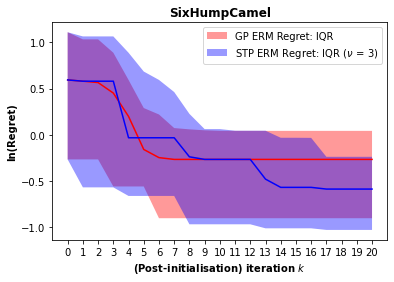

In [93]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_gp, color = 'Red')
plt.plot(median_stp, color = 'Blue')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'Red', alpha=0.4, label='GP ERM Regret: IQR')
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'Blue', alpha=0.4, label='STP ERM Regret: IQR ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!
